In [1]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from Target_Distibution import TARGET_FUNCTION

In [2]:
# Step 1: Define the QCBM Circuit
def qcbm_circuit(params, num_qubits, num_layers=2):
    """
    Construct a QCBM circuit with the specified number of layers (d).
    
    Args:
        params (np.ndarray): Array of parameters (size: num_qubits * 3 * num_layers).
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        
    Returns:
        QuantumCircuit: The parameterized QCBM circuit.
    """
    qc = QuantumCircuit(num_qubits)
    idx = 0

    for layer in range(num_layers):
        # Single-qubit rotations for each qubit in the layer
        for q in range(num_qubits):
            qc.rz(params[idx], q)
            qc.rx(params[idx + 1], q)
            qc.rz(params[idx + 2], q)
            idx += 3
        # Add entangling gates
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
    return qc


In [3]:
# Step 2: Define the Loss Function
def loss_function(params, num_qubits, num_layers, target_distribution):
    """
    Calculate the KL divergence between target and generated distributions.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        float: KL divergence.
    """
    qc = qcbm_circuit(params, num_qubits, num_layers)
    qc.measure_all()

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=8000).result()
    counts = result.get_counts()
    
    # Convert counts to probabilities
    generated_distribution = {k: v / 8000 for k, v in counts.items()}
    
    # Calculate KL divergence
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)
        print(generated_prob , " " ,np.log(target_prob / generated_prob))
    
    return kl_divergence


In [4]:
def gradient_computer(params,params_shift,num_qubits,  num_layers, target_distribution):
    qc_a = qcbm_circuit(params, num_qubits, num_layers)
    qc_a.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_a = transpile(qc_a, simulator)
    result_a = execute(qc_a, backend=simulator, shots=8000).result()
    counts_a = result_a.get_counts()
    
    # Normalize counts to probabilities
    generated_distribution_a = {k: v / 8000 for k, v in counts_a.items()}
    
    qc_b = qcbm_circuit(params_shift, num_qubits, num_layers)
    qc_b.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_b = transpile(qc_b, simulator)
    result_b = execute(qc_b, backend=simulator, shots=8000).result()
    counts_b = result_b.get_counts()

    # Normalize counts to probabilities
    generated_distribution_b = {k: v / 8000 for k, v in counts_b.items()}
    
    gradient_component=0
    for bitstring, target_prob in target_distribution.items():
        generated_prob_a = generated_distribution_a.get(bitstring, 1e-10)
        generated_prob_b = generated_distribution_b.get(bitstring, 1e-10)
        gradient_component -=  target_prob /generated_prob_a*generated_prob_b
        
    return gradient_component

In [5]:

# Step 3: Define the Gradient Computation
def compute_gradients(params, num_qubits, num_layers, target_distribution):
    """
    Compute gradients of the loss function using the parameter-shift rule.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        np.ndarray: Gradients of the loss function w.r.t. parameters.
    """
    gradients = np.zeros_like(params)
    shift = np.pi / 2  # Parameter shift value

    for i in range(len(params)):
        # Shift parameter up
        params_shifted_up = np.copy(params)
        params_shifted_up[i] += shift
        loss_up = gradient_computer(params, params_shifted_up, num_qubits, num_layers, target_distribution)

        # Shift parameter down
        params_shifted_down = np.copy(params)
        params_shifted_down[i] -= shift
        loss_down = gradient_computer(params, params_shifted_down, num_qubits, num_layers, target_distribution)

        # Compute gradient
        gradients[i] =loss_up - loss_down

    return gradients

In [6]:
# Step 4: Gradient Descent Training
def gradient_descent(initial_params, num_qubits, num_layers, target_distribution, learning_rate=0.1, max_iters=100):
    """
    Perform gradient descent to optimize QCBM parameters.
    
    Args:
        initial_params (np.ndarray): Initial QCBM parameters.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        learning_rate (float): Learning rate for parameter updates.
        max_iters (int): Maximum number of iterations.
        
    Returns:
        np.ndarray: Optimized parameters.
    """
    params = np.copy(initial_params)
    for iteration in range(max_iters):
        # Compute gradients
        gradients = compute_gradients(params, num_qubits, num_layers, target_distribution)
        
        # Update parameters
        params -= learning_rate * gradients
        
        # Compute loss for monitoring
        loss = loss_function(params, num_qubits, num_layers, target_distribution)
        print(f"Iteration {iteration + 1}, Loss: {loss}")
        if loss<0.1:
            break
    
    return params


C:\Users\Alice\AppData\Local\Temp\ipykernel_29048\2316695807.py:3: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(target_distribution, title="Target Distribution", bar_labels=False)


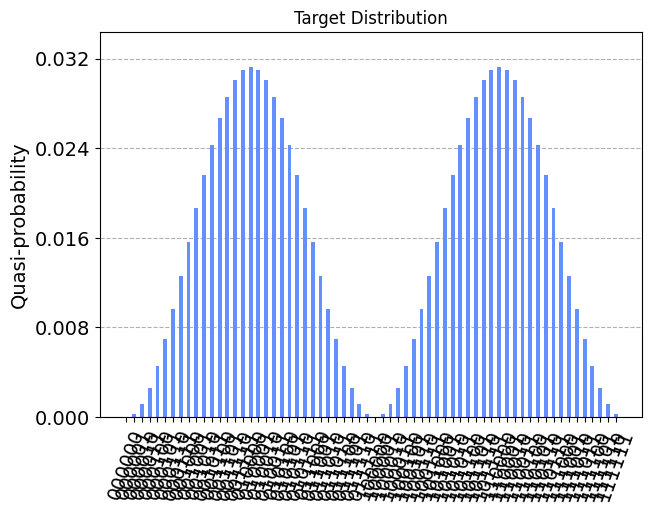

In [9]:
# Define target distribution
target_distribution = TARGET_FUNCTION.sinusoidal(6)
plot_histogram(target_distribution, title="Target Distribution", bar_labels=False)

In [10]:
# Step 5: Train the QCBM
num_qubits = 6
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution
target_distribution = TARGET_FUNCTION.sinusoidal(num_qubits)
plot_histogram(target_distribution, title="Target Distribution", bar_labels=False)
# Train using gradient descent
optimized_params = gradient_descent(
    initial_params, 
    num_qubits, 
    num_layers, 
    target_distribution, 
    learning_rate=0.1, 
    max_iters=100
)


C:\Users\Alice\AppData\Local\Temp\ipykernel_29048\2302234877.py:9: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(target_distribution, title="Target Distribution", bar_labels=False)
C:\Users\Alice\AppData\Local\Temp\ipykernel_29048\1349182268.py:5: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')
C:\Users\Alice\AppData\Local\Temp\ipykernel_29048\1349182268.py:7: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler

0.00225   -6.579254337005218
0.02825   -4.544303034971099
0.00025   1.5597253366444124
0.023875   -2.204602018770777
0.004625   -0.010554477636556208
0.02075   -1.0946404171051072
0.0435   -1.5062651785389896
0.005625   0.8046229134159867
0.00175   2.1892532826919253
0.060375   -1.1734842755410921
0.001875   2.4442865384562977
0.0235   0.033710837224361
0.002875   2.2276163931176045
0.012625   0.8183088068656106
0.023375   0.251545732695962
0.002875   2.37630976872126
0.01175   0.9781630105971253
0.019375   0.46837886773116333
0.0275   0.08902680319818704
0.013375   0.7606004892449642
0.0205   0.26324418122255566
0.004875   1.606591153924664
0.020625   0.04639126565792741
0.004125   1.5100248166450008
0.004875   1.1647489661775376
0.01475   -0.15939922127935827
0.013125   -0.3080230489220386
0.002875   0.881853155322287
0.02575   -1.7275127337819123
0.019625   -2.0085743960724547
0.0125   -2.35229766878373
0.015875   -3.9679551221574
0.008375   -71.96065285194179
0.0175   -4.0654104583

In [8]:
# Step 6: Generate Samples Using Trained QCBM
trained_qcbm = qcbm_circuit(optimized_params, num_qubits, num_layers)
trained_qcbm.measure_all()

simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm, simulator)
result = execute(trained_qcbm, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)


Generated Distribution: {'100111': 118, '011011': 116, '100011': 137, '111101': 39, '001100': 211, '011001': 112, '100000': 139, '001110': 218, '100101': 151, '111011': 92, '101110': 96, '000101': 82, '110010': 240, '010100': 151, '100110': 115, '111010': 88, '001111': 233, '011100': 116, '100100': 138, '111100': 38, '001101': 207, '000011': 31, '110100': 137, '101100': 119, '001000': 129, '101000': 148, '011110': 123, '111110': 40, '001011': 165, '100010': 141, '101001': 131, '010110': 137, '000000': 34, '110111': 146, '111000': 84, '111001': 115, '010111': 143, '101101': 122, '000100': 97, '110011': 237, '010101': 146, '101011': 136, '000010': 36, '110101': 163, '001010': 144, '100001': 119, '111111': 26, '010000': 106, '011010': 128, '000110': 112, '110001': 179, '101111': 105, '011000': 112, '011111': 135, '000001': 24, '101010': 124, '110110': 128, '000111': 88, '110000': 213, '001001': 134, '010011': 132, '011101': 124, '010010': 149, '010001': 121}


C:\Users\Alice\AppData\Local\Temp\ipykernel_17200\2819823184.py:7: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(trained_qcbm, backend=simulator, shots=8000).result()


c:\Users\Alice\miniconda3\envs\qiskit0.46\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


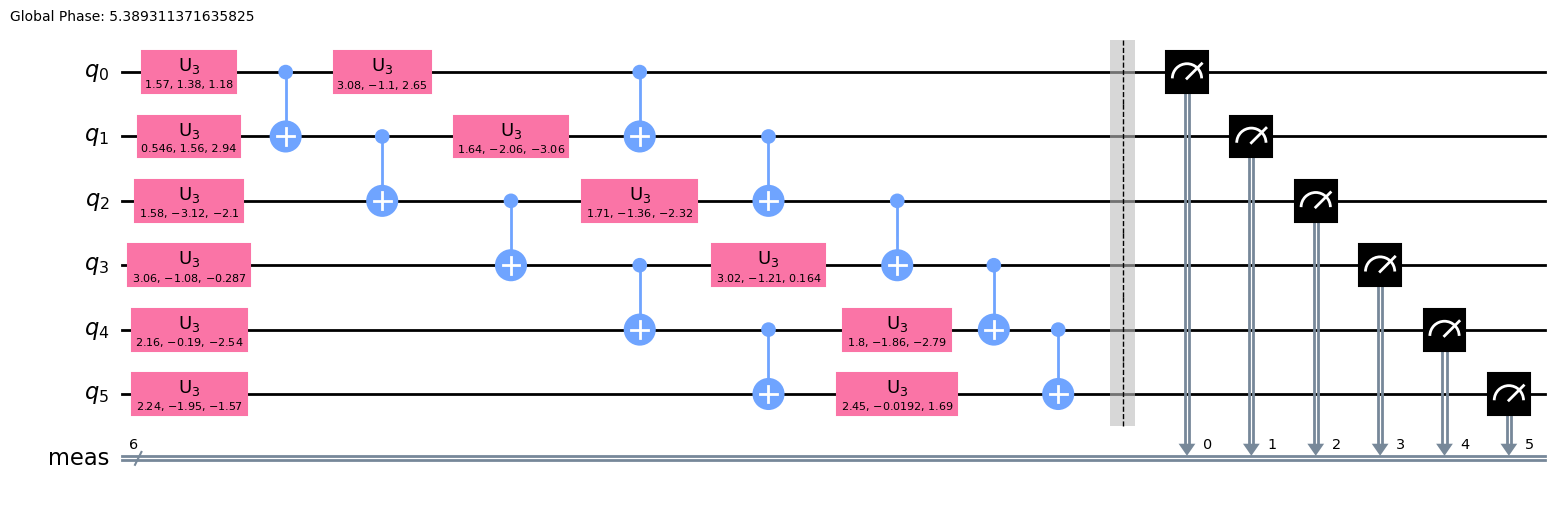

In [9]:
trained_qcbm.draw(output="mpl")

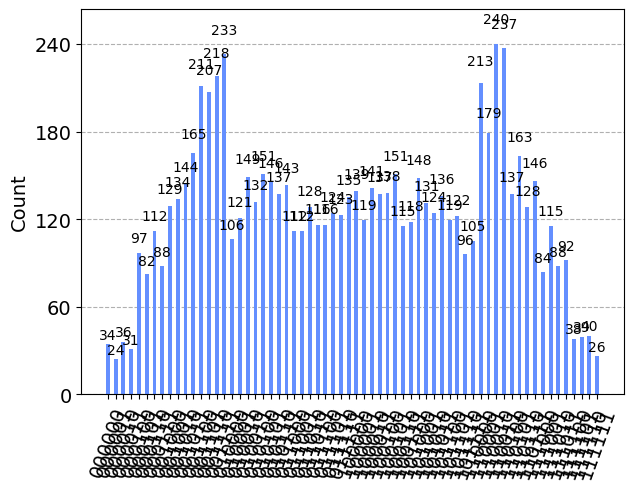

In [10]:
plot_histogram(counts)

In [ ]:
num_qubits = 6
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., |110⟩ with 0.8 probability, |001⟩ with 0.2 probability)
target_distribution = TARGET_FUNCTION.triangular(num_qubits)

result_cob = minimize(loss_function, initial_params, args=(num_qubits,num_layers, target_distribution), method='COBYLA')

# Optimized parameters
optimized_params_cob = result_cob.x
final_result=result_cob.fun
print(final_result)

In [ ]:
trained_qcbm_cob = qcbm_circuit(optimized_params_cob, num_qubits, num_layers)
trained_qcbm_cob.measure_all()
trained_qcbm_cob.draw(output="mpl")

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm_cob, simulator)
result = execute(trained_qcbm_cob, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

In [ ]:
plot_histogram(counts)

In [ ]:
plot_histogram(target_distribution)